In [1]:
from __future__ import print_function
import numpy as np
import pyemma
import pyemma.datasets
import simplex
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(7778)

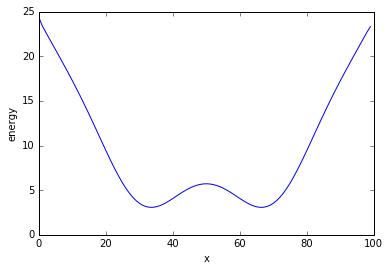

In [3]:
data = pyemma.datasets.load_2well_discrete()
plt.plot(-np.log(data.msm.stationary_distribution))
plt.ylabel('energy')
plt.xlabel('x')

In [4]:
# simulating non-connected data
# In a real application, the data could be completely disconnected if we start multiple simulations
# form different intial conditons.
trajs1 = [ data.generate_traj(10000, start=30, stop=48).astype(float) for _ in range(3) ]
trajs2 = [ data.generate_traj(10000, start=70, stop=52).astype(float) for _ in range(2) ]
trajs = trajs1 + trajs2
trajs = [ t + 3*np.random.randn(len(t)) for t in trajs ] # add some noise to model a second,
# non-metastable dimension that is not completely orthogonal to the x-coordinate of the double-well

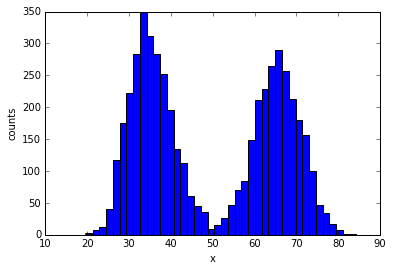

In [5]:
plt.hist(np.concatenate(trajs), bins=40);
plt.ylabel('counts')
plt.xlabel('x')

In [6]:
# select a very bad clustering 
dtrajs = pyemma.coordinates.assign_to_centers(data=trajs, centers=np.array([[40.0],[70.0]]))

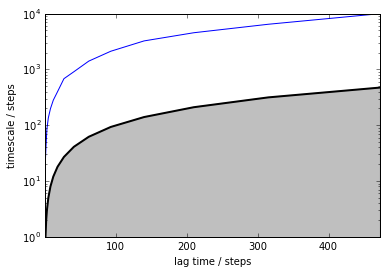

In [7]:
# go ahead and compute the MSM
its = pyemma.msm.its(dtrajs)
pyemma.plots.plot_implied_timescales(its)

In [8]:
# use some default algorithm
kmeans = pyemma.coordinates.cluster_kmeans(data=trajs, k=101)
dtrajs = kmeans.dtrajs

18-07-17 10:14:57 pyemma.coordinates.clustering.kmeans.KmeansClustering[1] INFO     Cluster centers converged after 9 steps.


18-07-17 10:15:02 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[2] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


/home/mi/fab/opt/anaconda2/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


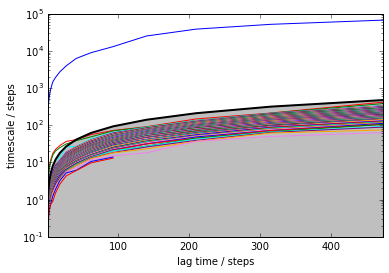

In [9]:
# also the default MSM is typically fooled
its = pyemma.msm.its(dtrajs)
pyemma.plots.plot_implied_timescales(its)

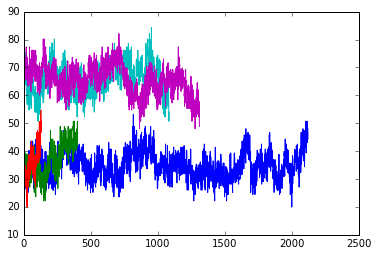

In [10]:
for d in dtrajs:
    plt.plot(kmeans.clustercenters[d])

In [11]:
# go to TICA space (in 1-D this is only a formal operation)
tics = pyemma.coordinates.tica(data=trajs).get_output()

In [12]:
# build core-set MSM
# a) find vertices
vertices = simplex.find_vertices_inner_simplex(tics)

pass 1


In [13]:
# b) comute core assignments
ctrajs = simplex.core_assignments(tics, vertices=vertices, f=0.55)

In [14]:
# TODO: plot cores, plot memberships!

(-0.1, 1.1)

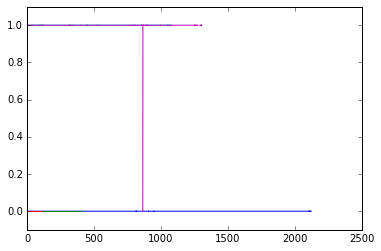

In [15]:
# plot core-to-core trajectories
for c in ctrajs:
    plt.plot(np.where(c>=0, c, np.nan))
plt.ylim((-0.1,1.1))
# sometimes there are some recorssing events left, despite the introduction of cores 

(-0.1, 1.1)

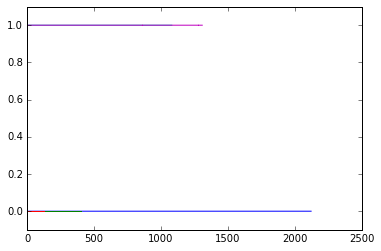

In [16]:
# c) We can filter these out by relabeling very short visits to cores as 'unassigned'.
ctrajs_metastable = simplex.filter_out_short_core_visits(ctrajs, cutoff=1) # usually a small life time cutoff is enough
for c in ctrajs_metastable:
    plt.plot(np.where(c>=0, c, np.nan))
plt.ylim((-0.1,1.1))

In [17]:
# d) now that we are more or less sure about the discretization quality, compute count matrices.
simplex.milestoning_count_matrix(ctrajs_metastable, lag=1)

/home/mi/fab/scripts/simplex.py:629: UserWarning: Milestoning code is not thoroughly tested, to be safe, please use pyemma.
  warnings.warn('Milestoning code is not thoroughly tested, to be safe, please use pyemma.')


array([[2648,    0],
       [   0, 2387]])

In [18]:
# TODO: make example where we can estimate a connected MSM

In [19]:
ltd = simplex.life_time_distributions(ctrajs_metastable)
for core in ltd:
    if core >= 0:
        print(core, ltd[core])

0 [2121, 402, 128]
1 [1081, 1308]


In [20]:
# basic hypothesis: there is always some dimension along which the dyanamics are irreversible and which is not
# well-discretized